In [4]:
#Libraries

import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from torch.utils.data import DataLoader


import cv2
from pathlib import Path
import random
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

- Obtaining images and captions

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/My\ Drive/data/data > /dev/null

- Functions for visualization

In [5]:
#Given an image, return captions

def extract_captions(image_name, captions_text):
    captions = []
    for line in captions_text.splitlines():
        parts = line.split(',')
        if len(parts) == 2 and parts[0] == image_name:
            captions.append(parts[1])

    return captions

def build_captions_dict(captions_text):
    captions_dict = {}
    for line in captions_text.splitlines():
        parts = line.split(',')
        if len(parts) == 2:
            if parts[0] not in captions_dict:
                captions_dict[parts[0]] = []
            captions_dict[parts[0]].append(parts[1])
    return captions_dict



In [6]:
#Visualization of image and one of its captions

def visualize_images(folder_path, captions_dict, num_images_per_row=3, max_caption_length=40):
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    random.shuffle(file_names) 
    file_names = file_names[:12]  

    num_images = len(file_names)
    num_rows = (num_images + num_images_per_row - 1) // num_images_per_row

    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(12, 9))

    for i, file_name in enumerate(file_names):
        img_path = os.path.join(folder_path, file_name)
        img = plt.imread(img_path)
        ax = axes[i // num_images_per_row, i % num_images_per_row]
        ax.imshow(img)
        ax.axis('off')

        caption = captions_dict.get(file_name, ["No caption"])

        if len(caption[0]) > max_caption_length:
            caption_lines = [caption[0][0:max_caption_length], caption[0][max_caption_length:]]
            ax.text(0.5, -0.3, caption_lines[0] + '\n' + caption_lines[1], transform=ax.transAxes, fontsize=10, ha='center')
        else:
            ax.text(0.5, -0.3, caption[0], transform=ax.transAxes, fontsize=10, ha='center')

    for j in range(len(file_names), num_rows * num_images_per_row):
        fig.delaxes(axes[j // num_images_per_row, j % num_images_per_row])

    plt.tight_layout()
    plt.show()


In [7]:
with open("captions.txt", "r") as file:
    captions_text = file.read()

captions_dict = build_captions_dict(captions_text)
visualize_images(folder_path="Images", captions_dict=captions_dict)


- Using ResNet18

In [20]:
# Load the feature extraction model

"""
"pretrained=True" argument - > Pre-trained weights for ResNet-18. 
 By default - > Weights trained on the ImageNet dataset.

"""
def load_model(model_name='resnet18'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    try:
        model_func = getattr(models, model_name)
        model = model_func(pretrained=True)
    except KeyError:
        raise ValueError(f'{model_name} is not a valid model name.')
    
    model = model.to(device)
    model.eval()
    
    return model




In [21]:
model = load_model('resnet18')

- Dealing with images

In [12]:
imageFilesDir = Path(r'Images')
files = list(imageFilesDir.rglob('*.jpg'))

mean = np.array([0., 0., 0.])
std = np.array([0., 0., 0.])

numSamples = len(files)

for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #To RGB
    im = im.astype(float) / 255. # Normalized pixels [0-1]
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j]) # j = 0 - > R, j = 1 - > G, j = 2 - > B
        std[j] += np.std(im[:,:,j])

mean = mean / numSamples
std = std / numSamples

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: [0.45802852 0.4460975  0.40391668]
Standard Deviation: [0.24219123 0.2332004  0.23719894]


In [13]:
#Mean: [0.45802852 0.4460975  0.40391668]
#Standard Deviation: [0.24219123 0.2332004  0.23719894]

preprocess = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image: ResNet model  - > (224,224,3)
    transforms.ToTensor(), # Img to Python Tensor
    transforms.Normalize(mean=mean, std=std), # image = (image - mean) / std
])

In [14]:
images_dir = "Images"

file_names = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
random_file = random.choice(file_names) # Pick one image at random

image_path = os.path.join(images_dir, random_file)
original_image = Image.open(image_path).convert('RGB')

normalized_image = preprocess(original_image)
normalized_image = torch.clamp(normalized_image, 0, 1)

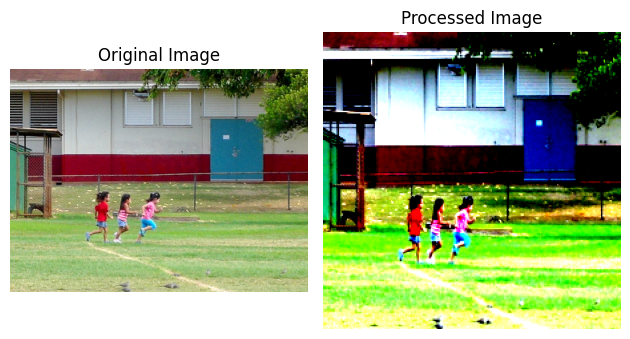

In [15]:
fig, axs = plt.subplots(1, 2)

# Original Image
axs[0].imshow(original_image)
axs[0].set_title("Original Image")

# Preprocessed Image
axs[1].imshow(normalized_image.permute(1, 2, 0))
axs[1].set_title("Processed Image")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

- Extracting Features

In [22]:
# Extracting features from images using ResNet50 😀

def extract_image_features(images_path, model_name, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataloader = DataLoader(os.listdir(images_path), batch_size=batch_size, shuffle=False)

    features = {}
    for batch in dataloader:
        batch_images = []
        for img_name in batch:
            if img_name.endswith('.jpg'):
                try:
                    img = Image.open(os.path.join(images_path, img_name)).convert('RGB')
                    img = preprocess(img).unsqueeze(0).to(device)
                    batch_images.append(img)
                except Exception as e:
                    print(f"Skipping image {img_name} due to error: {e}")
                    continue
        batch_images = torch.cat(batch_images, 0)
        
        with torch.no_grad():
            model = load_model(model_name)
            feature = model(batch_images)
        
        for img_name, feature in zip(batch, feature.cpu()):
            features[img_name] = torch.flatten(feature).numpy()
            
    return features

In [23]:
images_path = "Images"
features = extract_image_features(images_path, model_name = 'resnet18')

#shapes = [value.shape for value in features.values()]
#print(shapes)


- Activation maps of ResNet18

In [24]:
images_path = "Images"
file_names = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

random_index = random.randint(0, len(file_names) - 1)
img_name = file_names[random_index]

img_path = os.path.join(images_path, img_name)


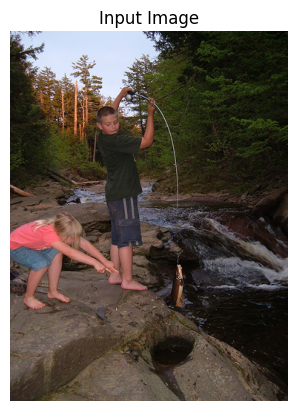

In [25]:
input_image = Image.open(img_path).convert('RGB')

plt.imshow(input_image)
plt.axis('off')
plt.title("Input Image")

input_image = preprocess(input_image)
input_image = input_image.unsqueeze(0) 


In [26]:
num_layers = 0
conv_layers = []

In [27]:
model_children = list(model.children())

In [28]:
model_children

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [29]:
for child in model_children:
  #print(child)

  if type(child) == nn.Conv2d:
    conv_layers.append(child)
    num_layers+=1    

  if type(child) == nn.Sequential: #Then, we look into the children of the child
    for layer in child.children():
      for layer in layer.children():
        if type(layer) == nn.Conv2d:
          #print(layer)
          conv_layers.append(layer)
          num_layers+=1      

In [ ]:
num_layers

In [ ]:
conv_layers

In [ ]:
input_image.shape

In [30]:
results = [conv_layers[0](input_image)]

for i in range(1, len(conv_layers)):
  results.append(conv_layers[i](results[-1])) #Use the last element of the list as input to the following layer

In [ ]:
len(results)

In [ ]:
results[0].shape # Because first layer - > 64 filters. Then, ouput 64 channels

In [ ]:
results[2].shape

Here, we create a file that contains multiple files, where each file corresponds to the resulting activation maps each layer:

In [31]:
output_dir = "Feature maps"
os.makedirs(output_dir, exist_ok=True)

for num_layer in range(len(results)):
    layer_dir = os.path.join(output_dir, f"Layer {num_layer + 1}")
    os.makedirs(layer_dir, exist_ok=True)
    
    layer = results[num_layer].squeeze()
    #print("Layer", num_layer + 1)
    
    for i, f in enumerate(layer):
        plt.imshow(f.detach().numpy())
        plt.axis("off")
        
        # Save the image file in the layer directory
        file_name = f"image_{i + 1}.png"
        file_path = os.path.join(layer_dir, file_name)
        plt.savefig(file_path)
        plt.close()
    
print("Layer outputs saved successfully.")


Layer outputs saved successfully.


The activation maps represent the presence of certain features or patterns in an input image.
- Darker regions in the activation maps indicate lower activation values or the absence of the corresponding features.
- Lighter regions indicate higher activation values or the presence of the features.

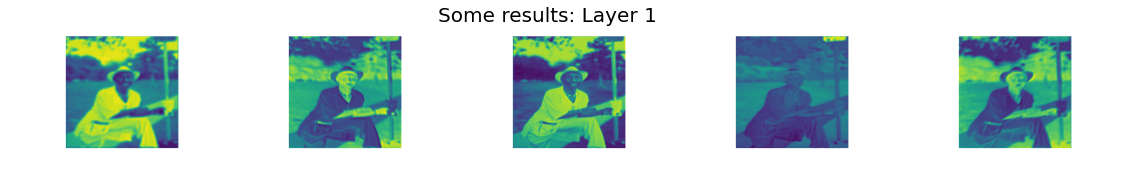

In [32]:
image_paths = ['Feature maps\Layer 1\image_10.png', "Feature maps\Layer 1\image_36.png", "Feature maps\Layer 1\image_38.png", "Feature maps\Layer 1\image_53.png","Feature maps\Layer 1\image_55.png"]

fig_width = 20
fig_height = 3
fig, axes = plt.subplots(1, len(image_paths), figsize=(fig_width, fig_height))

for i, image_path in enumerate(image_paths):
    #
    image = Image.open(image_path)

    axes[i].imshow(image)
    axes[i].axis('off')

fig.suptitle('Some results: Layer 1', x=0.5, y=0.9, ha='center',fontsize=20)
plt.show()


The features are more interpretable in the first layers as they directly correspond to visual patterns. However, as you move towards the last convolutional layer, the patterns become more complex and may appear as a combination of multiple low-level features.

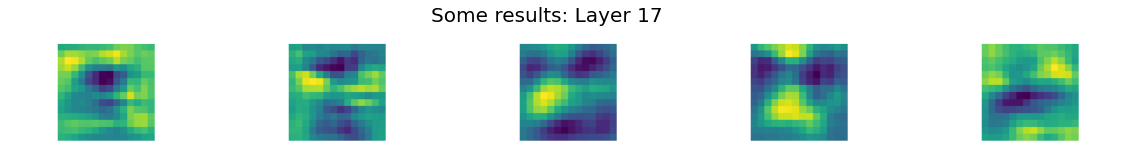

In [33]:
image_paths = ['Feature maps\Layer 17\image_10.png', "Feature maps\Layer 17\image_36.png", "Feature maps\Layer 17\image_38.png", "Feature maps\Layer 17\image_53.png","Feature maps\Layer 17\image_55.png"]

fig_width = 20
fig_height = 3
fig, axes = plt.subplots(1, len(image_paths), figsize=(fig_width, fig_height))

for i, image_path in enumerate(image_paths):
    #
    image = Image.open(image_path)

    axes[i].imshow(image)
    axes[i].axis('off')

fig.suptitle('Some results: Layer 17', x=0.5, y=0.9, ha='center',fontsize=20)
plt.show()

The last convolutional layer of the model learns high-level abstract representations - > not visually interpretable as recognizable patterns. 